In [1]:
# Imports
import torch
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn.reservoir as etrs
import echotorch.utils
import echotorch.utils.matrix_generation as mg
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Length of training samples
train_sample_length = 5000

# Length of test samples
test_sample_length = 1000

# How many training/test samples
n_train_samples = 10
n_test_samples = 5

# Batch size (how many sample processed at the same time?)
batch_size = 1

# Reservoir hyper-parameters
spectral_radius = 1.07
leaky_rate = 0.9261
input_dim = 1
reservoir_size = 410
connectivity = 0.1954
ridge_param = 0.00000409
input_scaling = 0.9252
bias_scaling = 0.079079

# Predicted/target plot length
plot_length = 200

# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

# Manual seed initialisation
np.random.seed(1)
torch.manual_seed(1)

In [30]:
# NARMA30 dataset
narma10_train_dataset = NARMADataset(train_sample_length, n_train_samples, system_order=10)
narma10_test_dataset = NARMADataset(test_sample_length, n_test_samples, system_order=10)

narma10_test_dataset.__getitem__(1)[0]

tensor([[0.4065],
        [0.1972],
        [0.3482],
        [0.4661],
        [0.2673],
        [0.4315],
        [0.2793],
        [0.4220],
        [0.2303],
        [0.1222],
        [0.0085],
        [0.4185],
        [0.0981],
        [0.2475],
        [0.0839],
        [0.3382],
        [0.4957],
        [0.1625],
        [0.1585],
        [0.4813],
        [0.3274],
        [0.2079],
        [0.1120],
        [0.4368],
        [0.4953],
        [0.4573],
        [0.4297],
        [0.0478],
        [0.4117],
        [0.0662],
        [0.1906],
        [0.1458],
        [0.1270],
        [0.4960],
        [0.3105],
        [0.2860],
        [0.0528],
        [0.0875],
        [0.3582],
        [0.0853],
        [0.1617],
        [0.3051],
        [0.0976],
        [0.4709],
        [0.1700],
        [0.2470],
        [0.3945],
        [0.0577],
        [0.4890],
        [0.3888],
        [0.3851],
        [0.4772],
        [0.4318],
        [0.3905],
        [0.4987],
        [0

In [4]:
# Data loader
trainloader = DataLoader(narma10_train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(narma10_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

trainloader

In [5]:
# Internal matrix
w_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=input_scaling,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=bias_scaling,
    apply_spectral_radius=False
)

In [6]:
# Create a Leaky-integrated ESN,
# with least-square training algo.
# esn = etrs.ESN(
esn = etrs.LiESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=1,
    leaky_rate=leaky_rate,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
    ridge_param=ridge_param
)

/usr/local/anaconda3/envs/phyre/lib/python3.6/site-packages/echotorch/utils/utility_functions.py:410: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2894.)
  return torch.max(torch.abs(torch.eig(m)[0])).item()


In [7]:
# For each batch
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

    # ESN need inputs and targets
    esn(inputs, targets)
# end for

In [8]:
# Now we finalize the training by
# computing the output matrix Wout.
esn.finalize()

In [9]:
# Get the first sample in training set,
# and transform it to Variable.
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
if use_cuda: train_u, train_y = train_u.cuda(), train_y.cuda()

In [10]:
# Make a prediction with our trained ESN
y_predicted = esn(train_u)

In [11]:
# Print training MSE and NRMSE
print(u"Train MSE: {}".format(echotorch.utils.mse(y_predicted.data, train_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, train_y.data)))
print(u"")

Train MSE: 0.0009240955114364624
Test NRMSE: 0.2835974874329001



In [27]:
# Get the first sample in test set,
# and transform it to Variable.
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()

In [28]:
# Make a prediction with our trained ESN
y_predicted = esn(test_u)

Test MSE: 0.001045107375830412
Test NRMSE: 0.2993665594053896



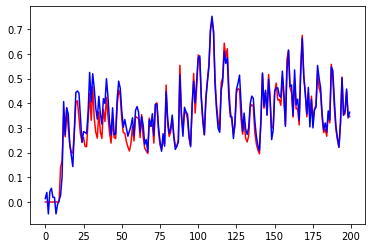

In [29]:
# Print test MSE and NRMSE
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, test_y.data)))
print(u"")

# Show target and predicted
plt.plot(test_y[0, :plot_length, 0].data, 'r')
plt.plot(y_predicted[0, :plot_length, 0].data, 'b')
plt.show()